In [28]:
import sys


In [156]:
!{sys.executable} -m pip install -r requirements.txt


Python(64187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 8.7 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 22.4 MB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 307 kB 38.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import requests
import wikipedia


In [35]:
def fetch_wikipedia_page(title):
    try:
        page_content = wikipedia.page(title).content
        return page_content
    except wikipedia.exceptions.PageError:
        print(f"Page titled '{title}' not found.")
        return None
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Disambiguation error: {e.options}")
        return None


In [ ]:
math = wikipedia.page("Mathematics")
text = math.content
text


'Mathematics is a field of study that discovers and organizes methods, theories and theorems that are developed and proved for the needs of empirical sciences and mathematics itself. There are many areas of mathematics, which include number theory (the study of numbers), algebra (the study of formulas and related structures), geometry (the study of shapes and spaces that contain them), analysis (the study of continuous changes), and set theory (presently used as a foundation for all mathematics).\nMathematics involves the description and manipulation of abstract objects that consist of either abstractions from nature or—in modern mathematics—purely abstract entities that are stipulated to have certain properties, called axioms.  Mathematics uses pure reason to prove properties of objects, a proof consisting of a succession of applications of deductive rules to already established results. These results include previously proved theorems, axioms, and—in case of abstraction from nature—s

In [48]:
def tokenize(text):
    # the above pattern gets all words in the text, removing punctuation and extra whitespaces
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())


In [80]:
tokens = tokenize(text)[:2000]


In [81]:
def mapping(tokens):
    # create a mapping from words to their unique integer IDs
    word_to_id = {}
    id_to_word = {}
    for index, token in enumerate(set(tokens)):
        word_to_id[token] = index
        id_to_word[index] = token
    return word_to_id, id_to_word


In [82]:
word_to_id, id_to_word = mapping(tokens)
print("word_to_id", word_to_id)
print("id_to_word", id_to_word)


word_to_id {'simplifies': 0, 'khwarizmi': 1, 'regarding': 2, 'but': 3, 'considerable': 4, 'systematizing': 5, 'representing': 6, 'configurations': 7, 'what': 8, 'manipulating': 9, 'functions': 10, 'dramatic': 11, 'grouped': 12, 'by': 13, 'study': 14, '19th': 15, 'resulting': 16, 'cartesian': 17, 'discovered': 18, 'bc': 19, 'complex': 20, 'objects': 21, 'solve': 22, 'mainly': 23, 'started': 24, 'split': 25, 'paradigm': 26, 'calculations': 27, 'surfaces': 28, 'until': 29, 'finance': 30, 'sophisticated': 31, 'oriented': 32, 'medicine': 33, 'influence': 34, '16th': 35, 'polynomials': 36, 'since': 37, 'differentiable': 38, 'fundamentally': 39, 'consider': 40, 'has': 41, 'mathematical': 42, 'division': 43, 'babylon': 44, 'fundamental': 45, 'find': 46, 'curves': 47, 'no': 48, 'segments': 49, 'arrangements': 50, 'see': 51, 'addresses': 52, 'nonlinear': 53, 'later': 54, 'become': 55, 'history': 56, 'unknown': 57, 'methods': 58, 'ancient': 59, 'planes': 60, 'largely': 61, 'types': 62, 'newton': 

In [83]:
np.random.seed(42)  # for reproducibility

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

def concat(*args):
    for y in args:
        # yield from does the flattening
        yield from y

def one_hot_encode(index, vocab_size):
    vec = [0] * vocab_size
    vec[index] = 1
    return vec


In [84]:
X, y = generate_training_data(tokens, word_to_id, 2)


In [85]:
X.shape


(7994, 638)

In [86]:
y.shape


(7994, 638)

In [87]:
# because the input is a sparse vector containing one-hot encoded vectors,
# the weight matrix effectively acts as a lookup table that moves one-hot
# encoded vectors to dense vectors in a different dimension—more precisely,
# the row space of the weight matrix. This is exactly what we want to achieve with embedding:
# representing words as dense vectors, a step-up from simple one-hot encoding
def init_network(vocab_size, embedding_dim):
    # first layer is d x e to convert one-hot encoded space to embedding space
    # second layer is e x d to project embeddings back to one-hot space
    model = {
        "w1": np.random.randn(vocab_size, embedding_dim),
        "w2": np.random.randn(embedding_dim, vocab_size)
    }
    return model


In [88]:
# choosing embedding dim 300
model = init_network(len(word_to_id), 300)


In [105]:
def forward(model, X, return_cache=True):
    cache = {}
    # A1 = X @ W1
    cache["a1"] = np.array(X @ model["w1"])
    # A2 = A1 @ W2 = X @ W1 @ W2
    cache["a2"] = np.array(cache["a1"] @ model["w2"])
    # Z = softmax(A2)
    cache["z"] = np.array(softmax(cache["a2"]))
    if return_cache:
        return cache
    return cache["z"]

def softmax(X):
    # Subtract the max value from each row for numerical stability
    X_stable = X - np.max(X, axis=1, keepdims=True)
    exp = np.exp(X_stable)
    return exp / (np.sum(exp, axis=1, keepdims=True) + 1e-10)  # Add epsilon to prevent division by zero


In [106]:
(X @ model["w1"]).shape


(7994, 300)

In [107]:
(X @ model["w1"] @ model["w2"]).shape


(7994, 638)

In [109]:
def backward(model, X, y, alpha):
    cache = forward(model, X)
    # dL/dA2 = z - y
    dA2 = cache['z'] - y
    # dL/dW2 = A1^T @ dL/dA2
    dW2 = cache['a1'].T @ dA2
    # dL/dA1 = dL/dA2 @ W2^T
    dA1 = dA2 @ model['w2'].T
    # dL/dW1 = X^T @ dL/dA1
    dW1 = X.T @ dA1
    assert(dW2.shape == model["w2"].shape)
    assert(dW1.shape == model["w1"].shape)
    # Update weights
    model['w1'] -= alpha * dW1
    model['w2'] -= alpha * dW2
    return cross_entropy(cache['z'], y)

def cross_entropy(z, y):
    epsilon = 1e-10  # Small value to prevent log(0)
    return - np.sum(np.log(z + epsilon) * y)


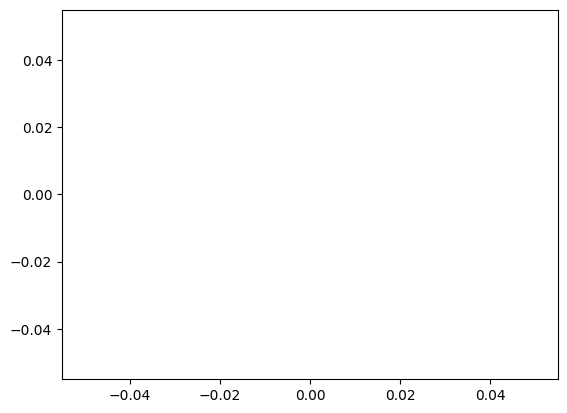

In [ ]:
n_iter = 300
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]
plt.plot(range(len(history)), history, color="skyblue")
plt.show()


In [ ]:
learning = one_hot_encode(word_to_id["proved"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)


TypeError: list indices must be integers or slices, not str

In [138]:
import re, numpy as np

# --- data prep ---
def tokenize(text):
    pattern = re.compile(r"\b[A-Za-z]+(?:'[A-Za-z]+)?\b")
    return [word for word in pattern.findall(text.lower()) if not any(char.isdigit() for char in word)]

def build_vocab(tokens):
    vocab = sorted(set(tokens))
    w2i = {w:i for i,w in enumerate(vocab)}
    i2w = {i:w for w,i in w2i.items()}
    return w2i, i2w

def one_hot(i, V):
    v = np.zeros(V, dtype=np.float32)
    v[i] = 1.0
    return v

def make_skipgram_pairs(tokens, w2i, window=2):
    X, Y = [], []
    V = len(w2i)
    for i, w in enumerate(tokens):
        center = one_hot(w2i[w], V)
        left  = range(max(0, i-window), i)
        right = range(i+1, min(len(tokens), i+window+1))
        for j in list(left)+list(right):
            X.append(center)
            Y.append(one_hot(w2i[tokens[j]], V))
    return np.stack(X), np.stack(Y)

# --- model ---
class SGNSoftmax:
    def __init__(self, V, d, seed=42):
        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(scale=0.1, size=(V, d)).astype(np.float32)
        self.W2 = rng.normal(scale=0.1, size=(d, V)).astype(np.float32)

    @staticmethod
    def softmax(A2):
        # rowwise softmax, numerically stable
        A2 = A2 - A2.max(axis=1, keepdims=True)
        exp = np.exp(A2)
        return exp / exp.sum(axis=1, keepdims=True)

    def forward(self, X):
        A1 = X @ self.W1           # (B,d)
        A2 = A1 @ self.W2          # (B,V)
        Z  = self.softmax(A2)      # (B,V)
        return A1, A2, Z

    def step(self, X, Y, lr=0.05):
        A1, A2, Z = self.forward(X)
        B = X.shape[0]
        dA2 = (Z - Y)              # (B,V)
        dW2 = A1.T @ dA2           # (d,V)
        dA1 = dA2 @ self.W2.T      # (B,d)
        dW1 = X.T @ dA1            # (V,d)
        # SGD update
        self.W1 -= lr * dW1
        self.W2 -= lr * dW2
        # cross-entropy
        # pick only true classes (rowwise dot of Y and logZ)
        loss = -np.sum(np.log(Z + 1e-12) * Y)
        return loss / B

# --- tiny demo corpus (replace with your own text) ---
text = '''Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions.[1] Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.[2]
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.
Statistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning.[4][5]
From a theoretical viewpoint, probably approximately correct learning provides a framework for describing machine learning.
The term machine learning was coined in 1959 by Arthur Samuel, an IBM employee and pioneer in the field of computer gaming and artificial intelligence.[6][7] The synonym self-teaching computers was also used in this time period.[8][9]
The earliest machine learning program was introduced in the 1950s when Arthur Samuel invented a computer program that calculated the winning chance in checkers for each side, but the history of machine learning roots back to decades of human desire and effort to study human cognitive processes.[10] In 1949, Canadian psychologist Donald Hebb published the book The Organization of Behavior, in which he introduced a theoretical neural structure formed by certain interactions among nerve cells.[11] Hebb's model of neurons interacting with one another set a groundwork for how AIs and machine learning algorithms work under nodes, or artificial neurons used by computers to communicate data.[10] Other researchers who have studied human cognitive systems contributed to the modern machine learning technologies as well, including logician Walter Pitts and Warren McCulloch, who proposed the early mathematical models of neural networks to come up with algorithms that mirror human thought processes.[10]
By the early 1960s, an experimental "learning machine" with punched tape memory, called Cybertron, had been developed by Raytheon Company to analyse sonar signals, electrocardiograms, and speech patterns using rudimentary reinforcement learning. It was repetitively "trained" by a human operator/teacher to recognise patterns and equipped with a "goof" button to cause it to reevaluate incorrect decisions.[12] A representative book on research into machine learning during the 1960s was Nilsson's book on Learning Machines, dealing mostly with machine learning for pattern classification.[13] Interest related to pattern recognition continued into the 1970s, as described by Duda and Hart in 1973.[14] In 1981 a report was given on using teaching strategies so that an artificial neural network learns to recognise 40 characters (26 letters, 10 digits, and 4 special symbols) from a computer terminal.[15]
Tom M. Mitchell provided a widely quoted, more formal definition of the algorithms studied in the machine learning field: "A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P if its performance at tasks in T, as measured by P, improves with experience E."[16] This definition of the tasks in which machine learning is concerned offers a fundamentally operational definition rather than defining the field in cognitive terms. This follows Alan Turing's proposal in his paper "Computing Machinery and Intelligence", in which the question "Can machines think?" is replaced with the question "Can machines do what we (as thinking entities) can do?".[17]
Modern-day machine learning has two objectives. One is to classify data based on models which have been developed; the other purpose is to make predictions for future outcomes based on these models. A hypothetical algorithm specific to classifying data may use computer vision of moles coupled with supervised learning in order to train it to classify the cancerous moles. A machine learning algorithm for stock trading may inform the trader of future potential predictions.[18]'''
tokens = tokenize(text)
w2i, i2w = build_vocab(tokens)
X, Y = make_skipgram_pairs(tokens, w2i, window=2)

# --- train ---
model = SGNSoftmax(V=len(w2i), d=10)
for epoch in range(50):
    loss = model.step(X, Y, lr=0.05)
# embeddings to use:
embeddings = model.W1  # rows align with vocab order


/var/folders/s_/y1_hxfjs6d704wyr6clkvdp80000gn/T/ipykernel_98761/1478655832.py:41: RuntimeWarning: invalid value encountered in subtract
  A2 = A2 - A2.max(axis=1, keepdims=True)


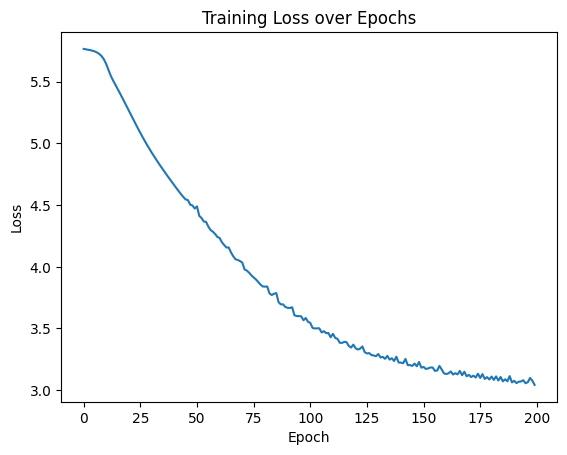

In [139]:
def train_model(model, X, Y, epochs=50, lr=0.05, batch_size=None):
    losses = []
    N = X.shape[0]
    for epoch in range(epochs):
        if batch_size is None:  # full batch
            loss = model.step(X, Y, lr)
        else:                   # mini-batch training
            idx = np.random.choice(N, batch_size, replace=False)
            loss = model.step(X[idx], Y[idx], lr)
        losses.append(loss)
    return losses

# Example: train and plot
model = SGNSoftmax(V=len(w2i), d=10)
losses = train_model(model, X, Y, epochs=200, lr=0.01)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()


In [140]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def nearest_neighbors(word, embeddings, w2i, i2w, k=5):
    if word not in w2i: return []
    idx = w2i[word]
    target = embeddings[idx]
    sims = []
    for i in range(len(i2w)):
        if i == idx: continue
        sims.append((i2w[i], cosine_similarity(target, embeddings[i])))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:k]


In [141]:
# for hyperparameter tuning
def run_experiment(tokens, w2i, i2w, dims, lrs, windows, epochs=50, probe_word="learning"):
    for d in dims:
        for lr in lrs:
            for window in windows:
                print(f"\n=== d={d}, lr={lr}, window={window} ===")
                X, Y = make_skipgram_pairs(tokens, w2i, window=window)
                model = SGNSoftmax(V=len(w2i), d=d)
                losses = train_model(model, X, Y, epochs=epochs, lr=lr)

                # Plot loss curve
                plt.figure()
                plt.plot(losses)
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title(f"Loss (d={d}, lr={lr}, window={window})")
                plt.show()

                # Nearest neighbors plot
                neighbors = nearest_neighbors(probe_word, model.W1, w2i, i2w, k=5)
                words, scores = zip(*neighbors) if neighbors else ([],[])
                plt.figure()
                plt.barh(words, scores)
                plt.xlabel("Cosine similarity")
                plt.title(f"Neighbors of '{probe_word}' (d={d}, lr={lr}, window={window})")
                plt.show()



=== d=10, lr=0.01, window=2 ===


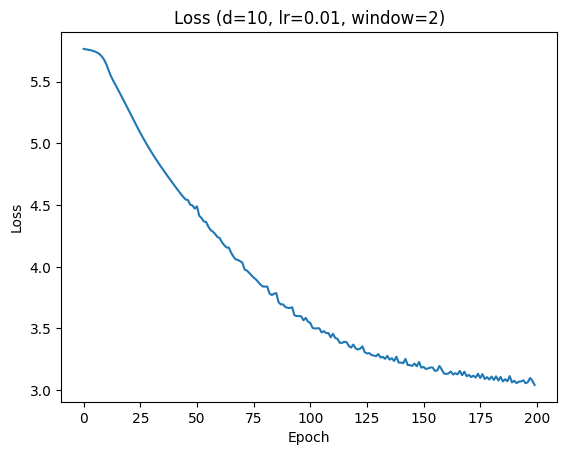

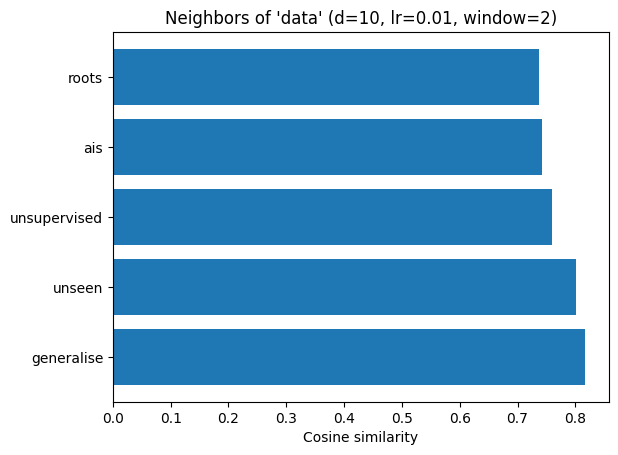


=== d=10, lr=0.01, window=5 ===


/var/folders/s_/y1_hxfjs6d704wyr6clkvdp80000gn/T/ipykernel_98761/1478655832.py:41: RuntimeWarning: invalid value encountered in subtract
  A2 = A2 - A2.max(axis=1, keepdims=True)


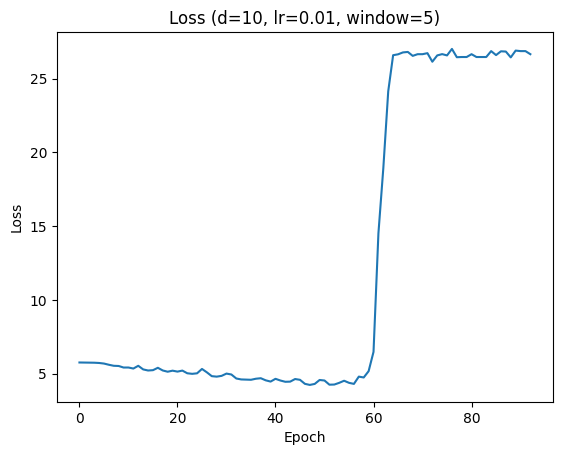

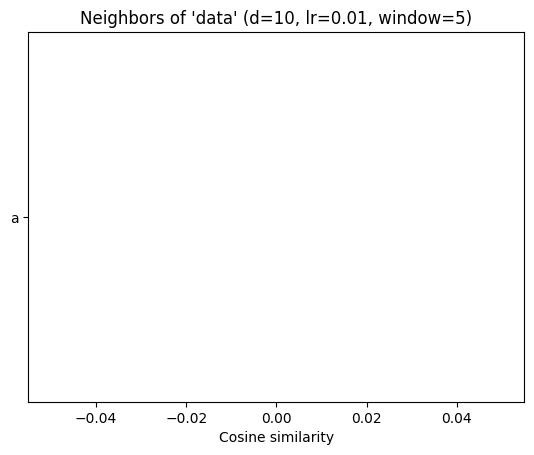


=== d=10, lr=0.05, window=2 ===


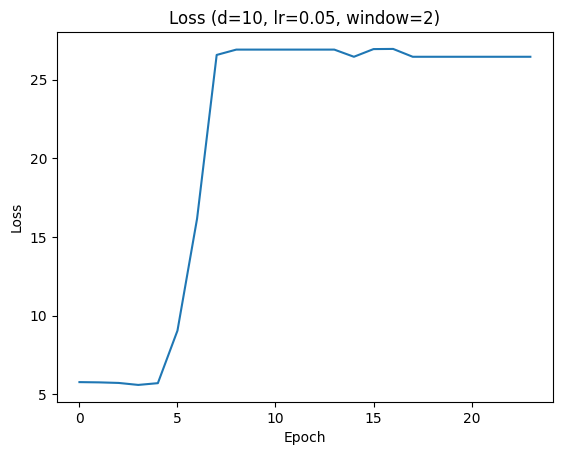

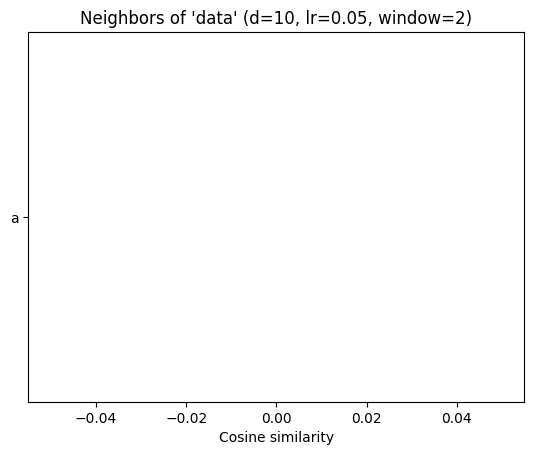


=== d=10, lr=0.05, window=5 ===


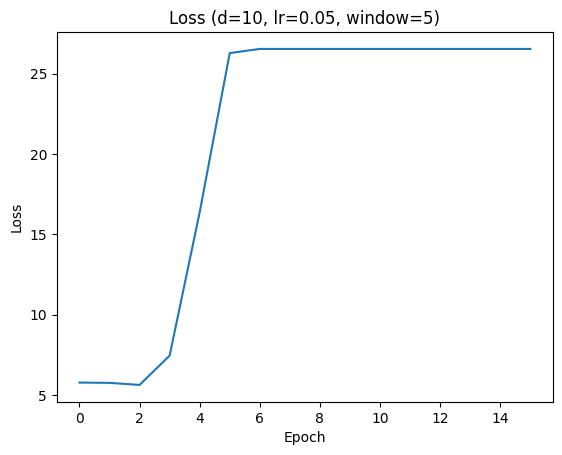

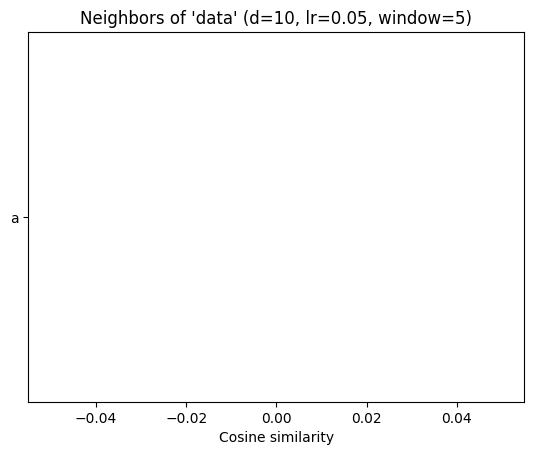


=== d=20, lr=0.01, window=2 ===


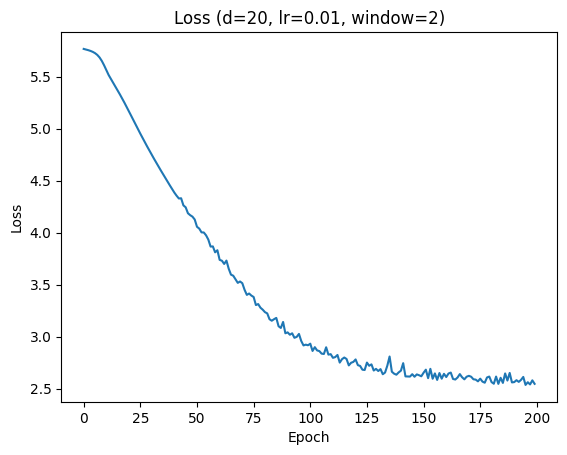

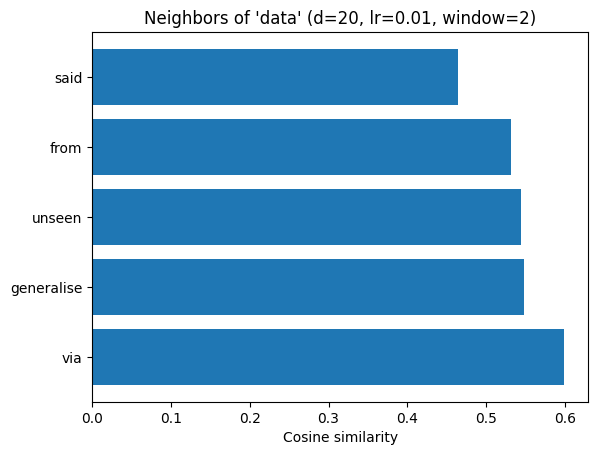


=== d=20, lr=0.01, window=5 ===


/var/folders/s_/y1_hxfjs6d704wyr6clkvdp80000gn/T/ipykernel_98761/1478655832.py:41: RuntimeWarning: overflow encountered in subtract
  A2 = A2 - A2.max(axis=1, keepdims=True)


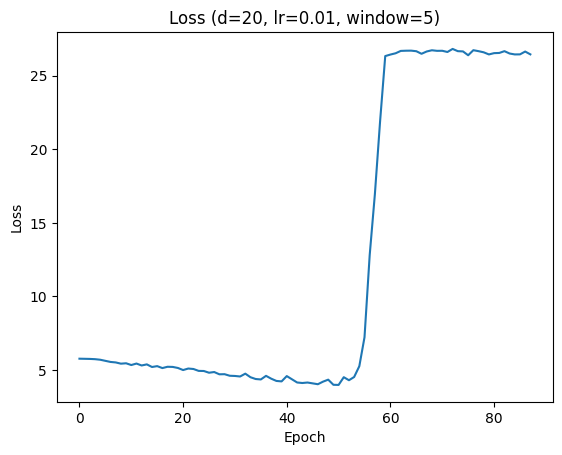

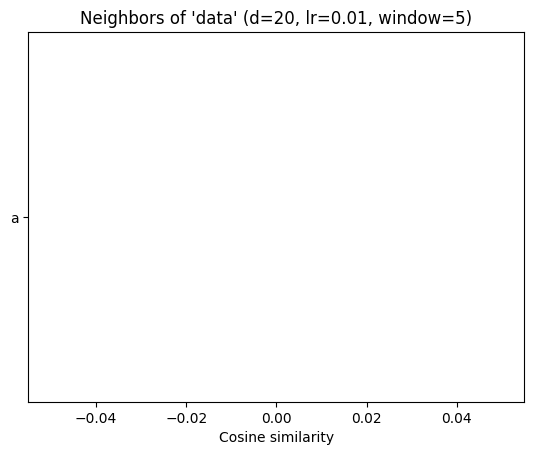


=== d=20, lr=0.05, window=2 ===


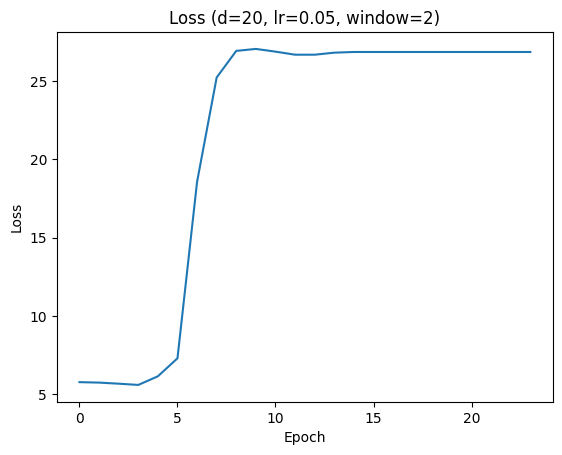

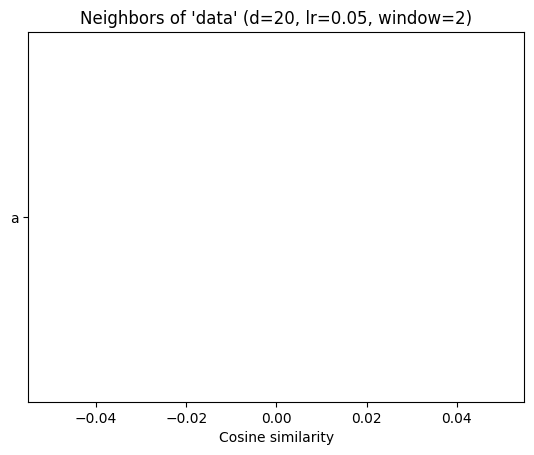


=== d=20, lr=0.05, window=5 ===


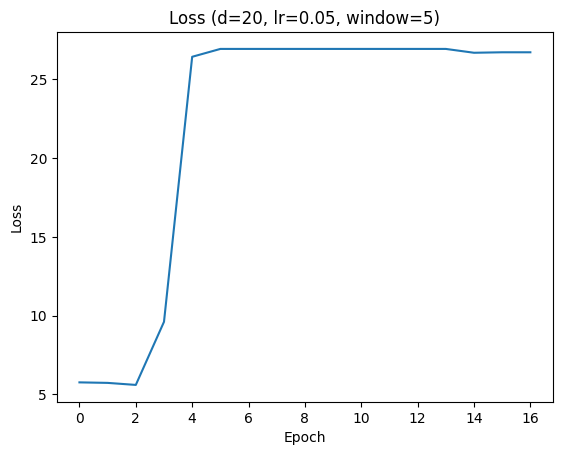

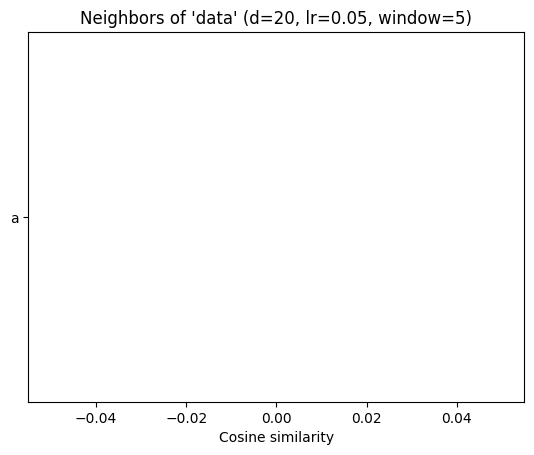


=== d=30, lr=0.01, window=2 ===


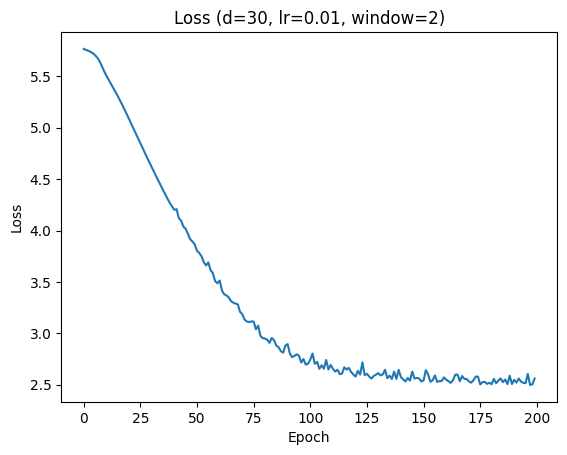

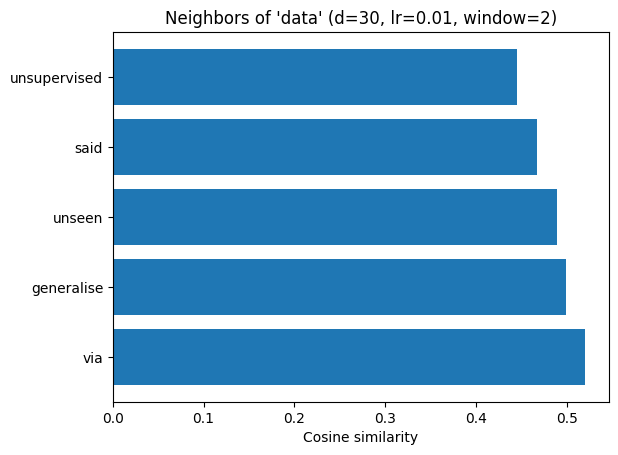


=== d=30, lr=0.01, window=5 ===


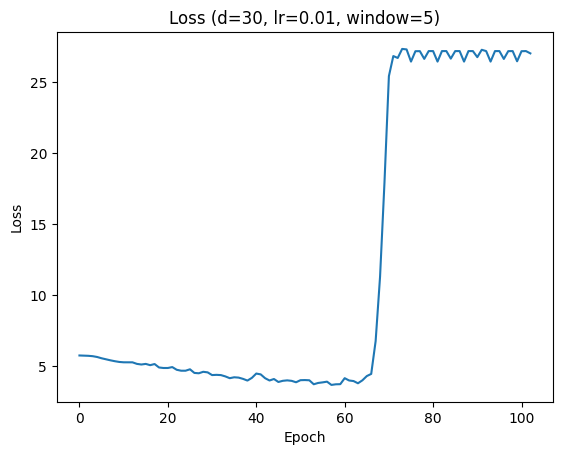

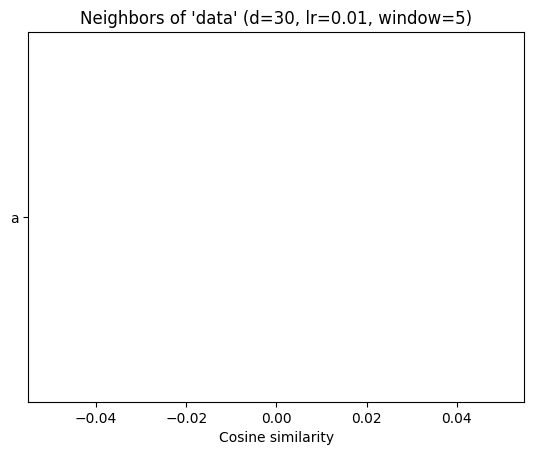


=== d=30, lr=0.05, window=2 ===


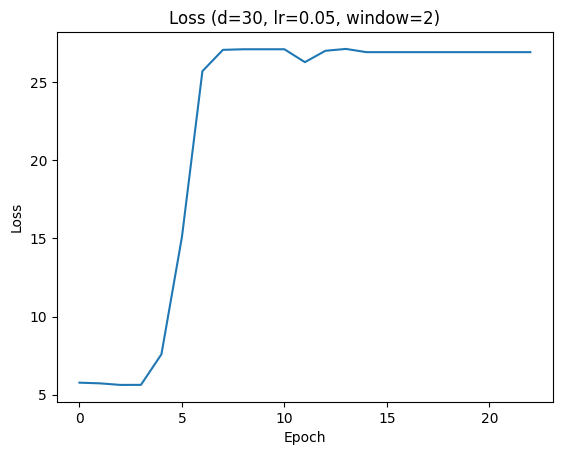

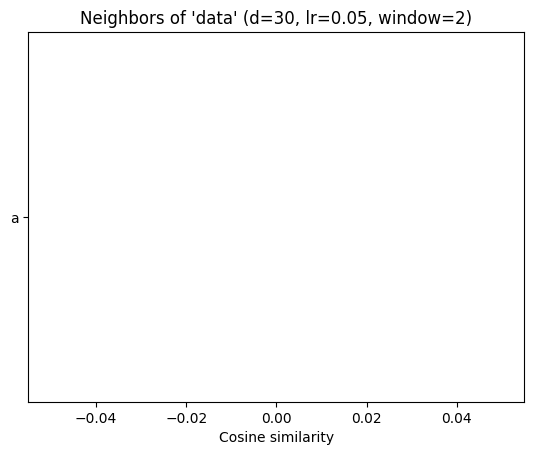


=== d=30, lr=0.05, window=5 ===


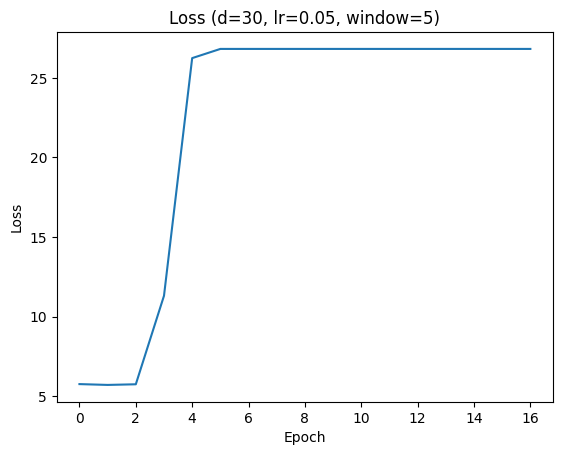

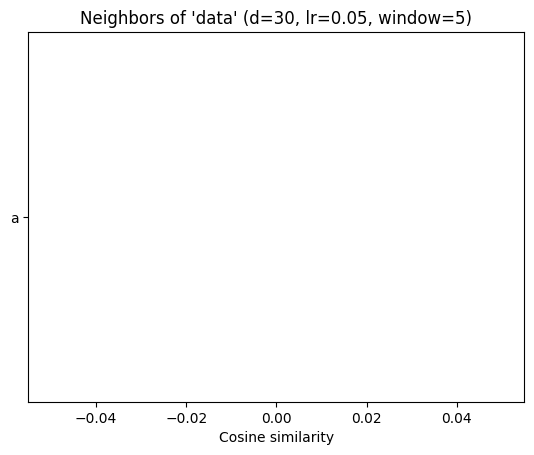

In [142]:
# run sweeps on the hyperparameters possible
dims = [10, 20, 30]
lrs = [0.01, 0.05]
windows = [2, 5]

run_experiment(tokens, w2i, i2w, dims, lrs, windows, epochs=200, probe_word="data")


In [ ]:
def get_embedding(model, word, w2i):
    if word not in w2i:
        print(f"'{word}' not in corpus")
        return None
    idx = w2i[word]
    return model.W1[idx]   # returns the learned dense vector


In [155]:
get_embedding(model, "machine", w2i)


array([-0.5444969 , -0.04840503, -0.07057491, -0.17469746, -0.62556905,
        0.80194134,  1.1345656 ,  0.6682865 , -1.6296313 ,  0.3911639 ],
      dtype=float32)

In [157]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embeddings(model, words, w2i, method="pca"):
    vectors, valid_words = [], []
    for w in words:
        if w in w2i:
            vectors.append(model.W1[w2i[w]])
            valid_words.append(w)
        else:
            print(f"'{w}' not in vocab")

    if not vectors:
        print("No valid words to plot.")
        return
    
    X = np.vstack(vectors)

    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=5)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    coords = reducer.fit_transform(X)

    # Plot
    plt.figure(figsize=(6,6))
    plt.scatter(coords[:,0], coords[:,1])
    for word, (x,y) in zip(valid_words, coords):
        plt.text(x+0.01, y+0.01, word, fontsize=10)
    plt.title(f"{method.upper()} projection of embeddings")
    plt.show()


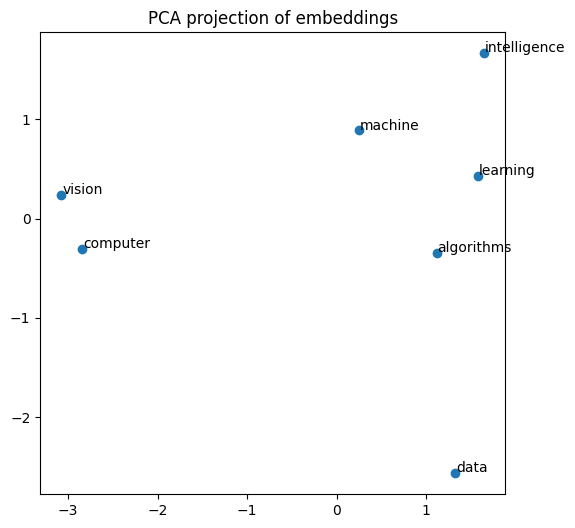

Python(64257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


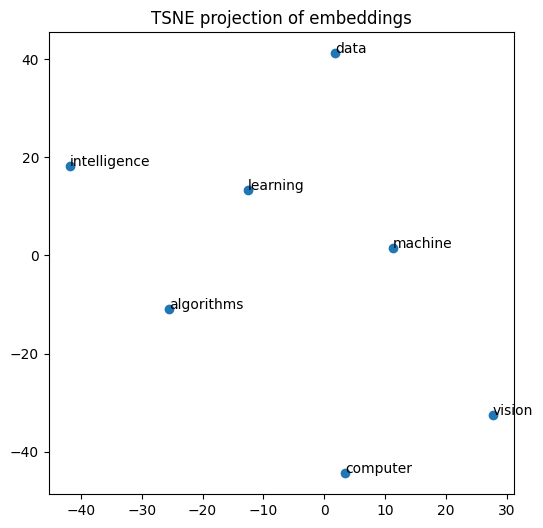

In [158]:
words_to_plot = ["machine", "learning", "algorithms", "data", "intelligence", "computer", "vision"]
plot_embeddings(model, words_to_plot, w2i, method="pca")
plot_embeddings(model, words_to_plot, w2i, method="tsne")
